<p><img alt="udeA logo" height="150px" src="https://github.com/freddyduitama/images/blob/master/logo.png?raw=true" align="left" hspace="50px" vspace="0px" style="width:107px;height:152px;"></p>
<h1><font color='0B5345'> <center>
Práctica 3. Parte 1: Análisis estadístico de señales ECG </center></font></h1>
<font  face="Courier New" size="3">
<p1><center> Angie Triana - Erika Gómez - Ana Carolina Mejía</center></p1>

<p3><center><b><font color='0B5345' face="Lucida Calligraphy,Comic Sans MS,Lucida Console" size="5">Universidad de Antioquia</font></b> </center></p3>

In [83]:
!pip install pingouin

In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio
import seaborn as sns
from scipy import stats
import pingouin as pg
from scipy.signal import find_peaks
from statsmodels.stats.diagnostic import lilliefors


## Procedimiento

### 1. Implementación de funciones

#### Función que permite calcular el valor cuadrático medio (RMS) de una señal. El valor RMS se define en forma discreta con N número de muestras, como:

<img src='RMS.jpeg'>

In [85]:
def rms(señal): #Recibe un arreglo de numpy (señal).
    valor_rms = np.sqrt(np.mean(señal**2))
    return valor_rms

__Prueba__

In [86]:
señal = np.array([6,7,10,1,3])

In [87]:
valor_rms = rms(señal)

In [88]:
print(f'El valor RMS de la señal es: {valor_rms}')

El valor RMS de la señal es: 6.244997998398398


### 2. Analísis estadístico: Señales de Electrocardiografía

<img src='Punto 1.jpeg'>

#### __Cargado de archivos .mat__

In [89]:
signal_data = sio.loadmat('signals.mat')

#### __Exploración del archivo__

In [90]:
print(signal_data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'Fs', 'ECG_asRecording', 'ECG_filtered', 'EMG_filtered1', 'EMG_filtered2', 'EMG_asRecording1', 'EMG_asRecording2'])


#### __Extracción de la señal sin filtrado__

In [91]:
ECG_asRecording = signal_data['ECG_asRecording']

In [92]:
ECG_asRecording.shape #Se visualiza su forma para conocer el número total de muestras obtenidas.

(1, 30720)

#### __Extracción de la señal filtrada__

In [93]:
ECG_filtered=signal_data['ECG_filtered']

#### __Determinación de la duración de la señal__

In [94]:
Fs = signal_data['Fs'] #Frecuencia de muestreo
print(Fs)

[[1024]]


In [95]:
ECG_asRecording.size #Se visualiza el parámetro "size" para conocer el número total de muestras tomadas

30720

In [96]:
duration = ECG_asRecording.size/1024

In [97]:
duration

30.0

##### __Número total de muestras__ = 30720
##### __Frecuencia de muestreo__ = 1024 Hz
##### __Duración de la señal__ = 30 segundos

#### __Creación del vector de tiempo__

Para crear el vector de tiempo, se construye un vector que inicie en 0 y vaya hasta 30 con un paso de 1/Fs, que corresponde al periodo de la señal.

In [98]:
time_vector = np.arange(0, duration, 1/1024)

In [99]:
time_vector.shape #El vector de tiempo tiene una sola dimensión, por lo tanto, se le hará un reshape a la señal de ECG.

(30720,)

Se aplica el método np.flatten() a las señales extraídas (filtrada y no filtrada) de modo que sea posible realizar las gráficas para su visualización y posterior comparación.

In [100]:
ECG_rs = ECG_asRecording.flatten()
ECG_filtered_rs = ECG_filtered.flatten() #Se realiza un cambio en la forma para que quede de una sola dimensión.

In [101]:
ECG_rs.shape #Ahora tienen la misma dimensión que el vector tiempo.

(30720,)

<img src='Punto 2.jpeg'>

#### __Gráfico de la señal filtrada y sin filtrar__

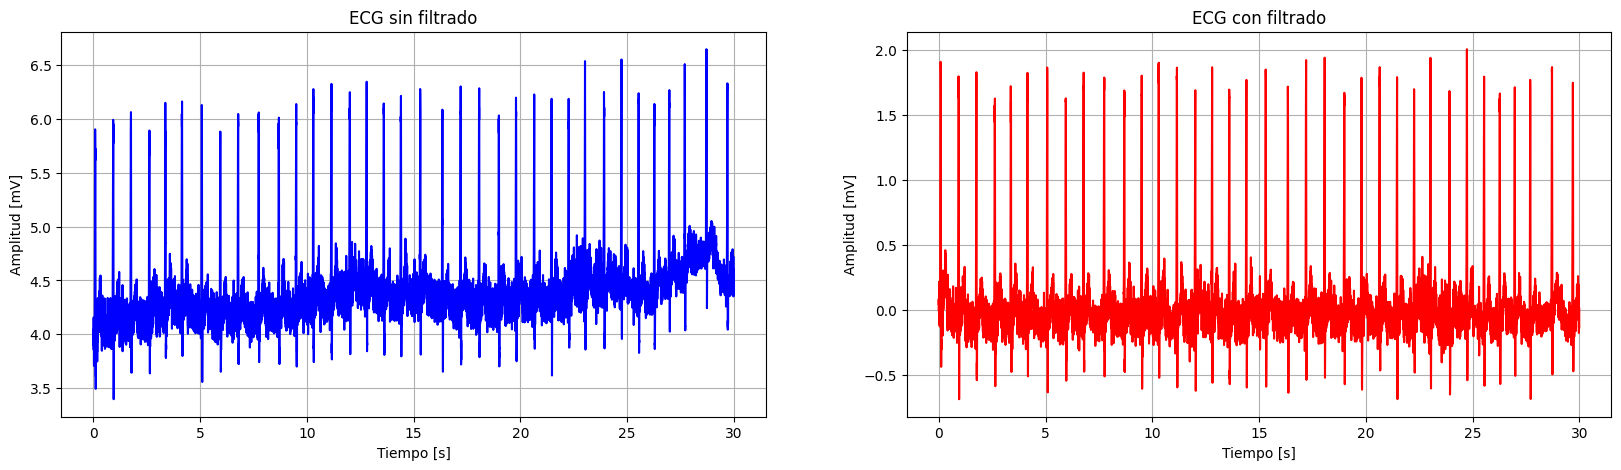

In [102]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.title('ECG sin filtrado')
plt.plot(time_vector, ECG_rs/1000, color='blue')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud [mV]')
plt.grid(True)

plt.subplot(1,2,2)
plt.title('ECG con filtrado')
plt.plot(time_vector, ECG_filtered_rs/1000, color='red')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud [mV]')

plt.subplots_adjust(wspace=0.2)
plt.grid(True)
plt.show()

En la señal de ECG sin proceso de filtrado se puede observar una línea de base inestable, que sufre fluctuaciones que se visualizan como un desplazamiento hacia arriba, lo que impide un análisis preciso de la amplitud en diferentes instantes de tiempo, puesto que no se tiene una línea clara de referencia. Sin embargo, la amplitud de la señal se encuentra alrededor de 2-3mV. Posterior al filtrado, se remueve dicha tendencia lineal, y se elimina un offset en la señal que se encontraba en 4mV (posiblemente por ruido durante la adquisición), posicionándose la línea base en 0, tomando ahora valores tanto positivos como negativos para la amplitud, sin verse modificada esta última respecto a la señal sin filtrado. Adicionalmente, se observan que se removieron las oscilaciones de baja frecuencia entre los picos de la señal, por lo que posiblemente se utilizó un filtro pasa altas, con una frecuencia de corte en 0.5 Hz __(Recordemos que la frecuencia de interés de la señal ECG se encuentra entre el rango de 0.5 a 40 Hz)__, en combinación con un filtro pasabajas, con una frecuencia de corte en 40 Hz, para eliminar ruido fisiológico o producido por interferencia electromagnética [1].

<img src='Punto 3.jpeg'>

<img src='Punto 4.jpeg'>

#### __Gráfico, promedio, desviación estándar, varianza y valor RMS de un ciclo cardiaco en la señal de ECG sin filtrar y filtrada__

Para la extracción del ciclo, analizamos que pueda visualizarse la secuencia de ondas PQRST característica de la señal ECG.

In [103]:
ECGnf_cycle = ECG_rs[0:750] #Extracción del ciclo de la señal ECG "cruda"
ECGf_cycle = ECG_filtered_rs[0:750] #Extracción del ciclo de la señal ECG filtrada.
cycle_time = time_vector[0:750]

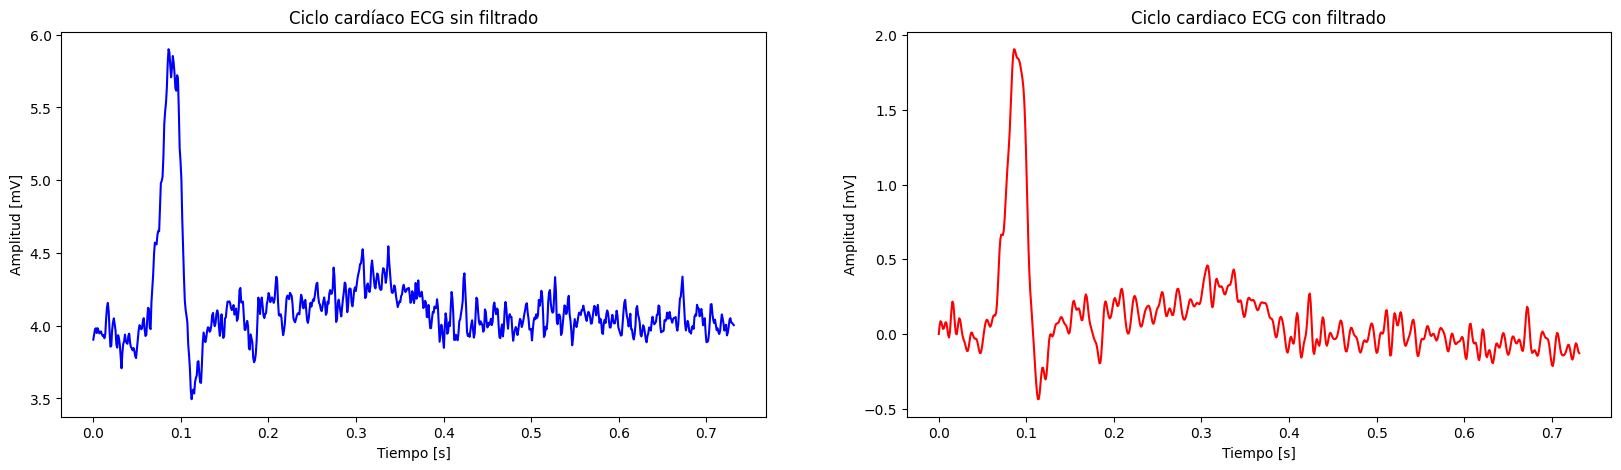

In [104]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.title('Ciclo cardíaco ECG sin filtrado')
plt.plot(cycle_time, ECGnf_cycle/1000, color='blue')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud [mV]')

plt.subplot(1,2,2)
plt.title('Ciclo cardiaco ECG con filtrado')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud [mV]')
plt.subplots_adjust(wspace=0.2)
plt.plot(cycle_time,ECGf_cycle/1000, color='red')
plt.show()

##### Observamos que en un rango de 0-750 ms es posible visualizar las ondas, P, T y el complejo QRS característico de la señal de electrocardiografía, incluyendo el periodo refractario donde el corazón se prepara para el siguiente latido (ciclo). Posteriormente, hacemos la extracción del promedio, valor RMS, desviación estándar y varianza de ambos ciclos.

In [105]:
promedios = pd.Series({'ECG sin filtrado': ECGnf_cycle.mean(), 'ECG filtrado':ECGf_cycle.mean()})
valores_rms = pd.Series({'ECG sin filtrado': rms(ECGnf_cycle), 'ECG filtrado':rms(ECGf_cycle)})
desviaciones_estandar = pd.Series({'ECG sin filtrado': ECGnf_cycle.std(), 'ECG filtrado':ECGf_cycle.std()})
varianza = pd.Series({'ECG sin filtrado': ECGnf_cycle.var(), 'ECG filtrado':ECGf_cycle.var()})

In [106]:
medidas = pd.DataFrame({'Promedio': promedios, 'RMS': valores_rms, 'Desviación estándar': desviaciones_estandar, 'Varianza':varianza})

In [107]:
medidas

,Promedio,RMS,Desviación estándar,Varianza
ECG sin filtrado,4122.325835,4133.709114,306.562809,93980.755841
ECG filtrado,104.704167,339.261484,322.700158,104135.392193


Para la señal ECG sin filtrado, se observan unos valores muy elevados para la media. Esto puede deberse a que la línea base de la señal presenta una tendencia lineal ascendente, alejándose de un valor central. En cuanto al RMS, que puede considerarse una representación de la energía total de la señal, también se obtuvo un valor elevado, lo que da cuenta de la presencia de una cantidad considerable de artefactos y ruido en la misma. Adicionalmente, dicha presencia de ruido, sea de origen fisiológico, por movimiento (de los electrodos o del paciente) o por interferencia electromagnética, inducen un incremento tanto de la varianza como de la desviación estándar de los datos debido a las fluctuaciones de voltaje respecto a la media.

Posterior al proceso de filtrado, disminuye el promedio y el valor RMS de la señal, a causa de la eliminación del offset y la tendencia lineal que presentaba la señal original, junto con la aplicación del filtro, mediante el cual se removieron las frecuencias que no se encontrarán dentro del rango de interés correspondiente a la señal ECG (0.5 - 40 Hz), identificadas como ruido [1]. Sin embargo, hubo un incremento para las medidas de variabilidad. Es posible que la causa sea la inclusión del periodo refractario del corazón previo al inicio de un nuevo ciclo, puesto que, como se puede observar en los gráficos, presenta oscilaciones variables, siendo una región bastante inestable de la señal.

De acuerdo a lo anterior, es posible extraer las medidas exclusivamente del intervalo de tiempo del ciclo cardiaco que comprende las ondas P, T y el complejo QRS, y observar si hay algún cambio al limitar el análisis a este segmento de la señal (que para el primer ciclo registrado, va hasta los 200 ms aproximadamente)

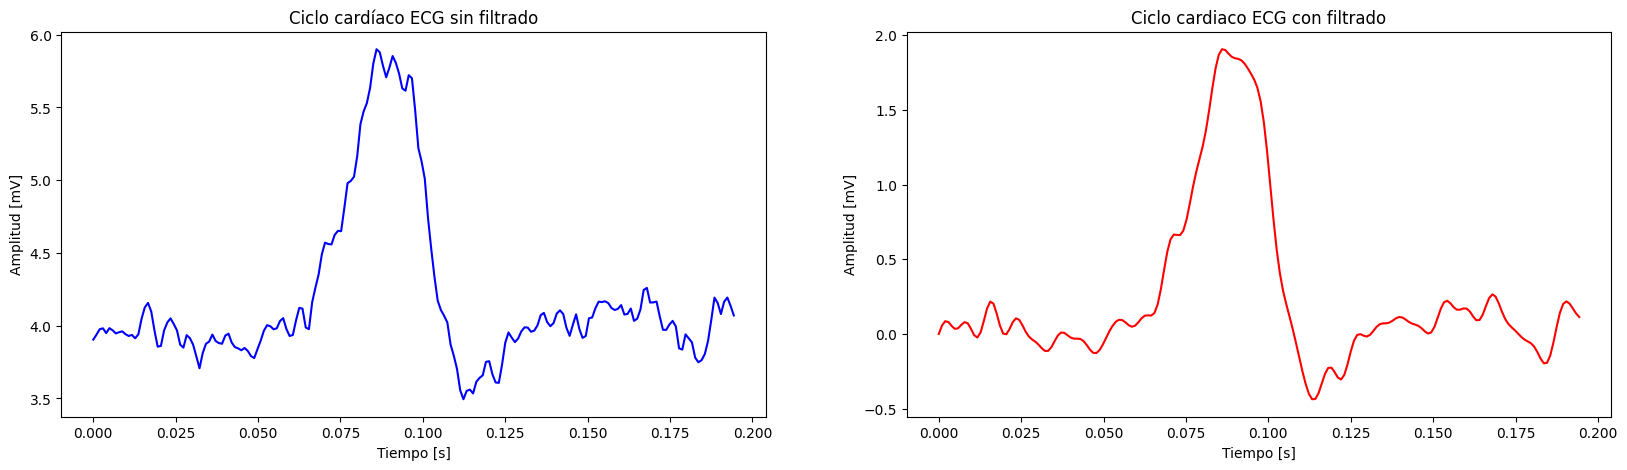

In [108]:
ECGnf_cycle = ECG_rs[0:200] #Extracción del ciclo de la señal ECG "cruda"
ECGf_cycle = ECG_filtered_rs[0:200] #Extracción del ciclo de la señal ECG filtrada.
cycle_time = time_vector[0:200]

plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.title('Ciclo cardíaco ECG sin filtrado')
plt.plot(cycle_time, ECGnf_cycle/1000, color='blue')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud [mV]')

plt.subplot(1,2,2)
plt.title('Ciclo cardiaco ECG con filtrado')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud [mV]')
plt.subplots_adjust(wspace=0.2)
plt.plot(cycle_time,ECGf_cycle/1000, color='red')
plt.show()

In [109]:
promedios = pd.Series({'ECG sin filtrado': ECGnf_cycle.mean(), 'ECG filtrado':ECGf_cycle.mean()})
valores_rms = pd.Series({'ECG sin filtrado': rms(ECGnf_cycle), 'ECG filtrado':rms(ECGf_cycle)})
desviaciones_estandar = pd.Series({'ECG sin filtrado': ECGnf_cycle.std(), 'ECG filtrado':ECGf_cycle.std()})
varianza = pd.Series({'ECG sin filtrado': ECGnf_cycle.var(), 'ECG filtrado':ECGf_cycle.var()})
medidas = pd.DataFrame({'Promedio': promedios, 'RMS': valores_rms, 'Desviación estándar': desviaciones_estandar, 'Varianza':varianza})

In [110]:
medidas

,Promedio,RMS,Desviación estándar,Varianza
ECG sin filtrado,4187.809591,4224.161148,552.981221,305788.230940
ECG filtrado,251.347788,606.447811,551.908722,304603.237148


En este caso, se da una disminución en las desviación estándar y la varianza, aunque la diferencia realmente es mínima. No obstante, se entiende que los valores elevados para las medidas de variabilidad es un comportamiento normal debido a la naturaleza de la señal de ECG, que presenta un rango que podría considerarse amplio, tanto en frecuencia como el voltaje, teniendo ciertas fluctuaciones por los cambios entre las diferentes fases del ciclo cardiaco.

<img src='Punto 5.jpeg'>

#### __Extracción de 15 ciclos de la señal filtrada, cálculo de su promedio y varianza__

Para la extracción de ciclos, se implementará el método find_peaks de Scipy, de manera que se identifiquen los picos R característicos del ECG. Posteriormente, se establecerán umbrales a la derecha y a la izquierda del pico, de modo que se pueda visualizar tanto el complejo QRS como las ondas P y T durante el ciclo.

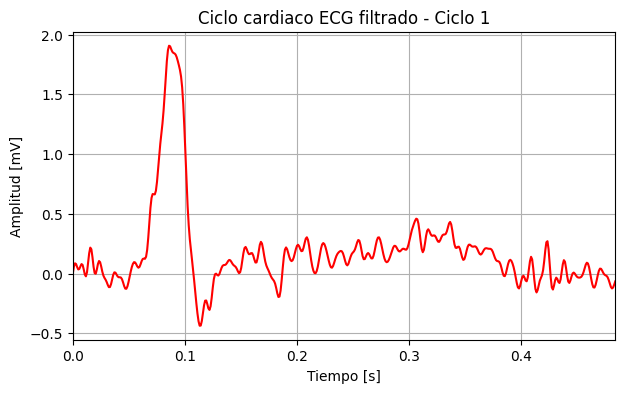

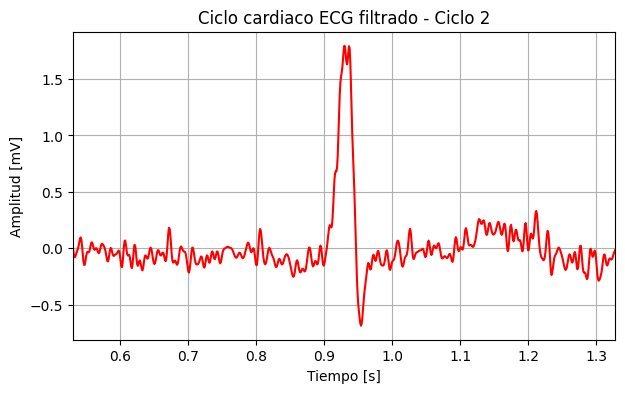

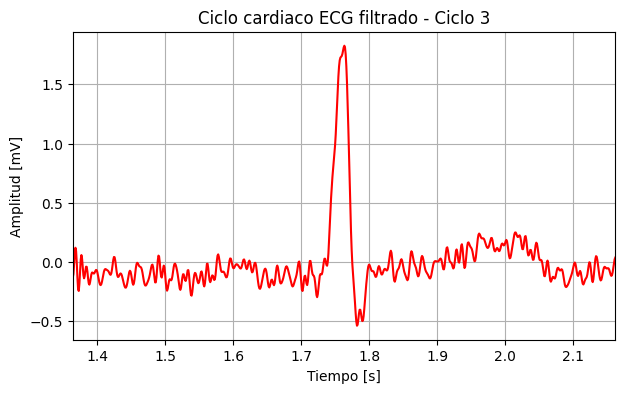

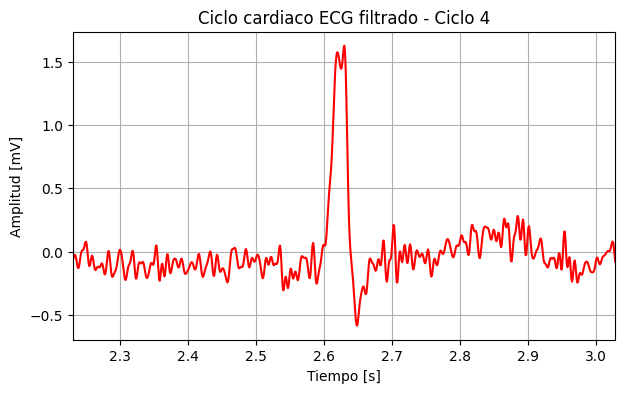

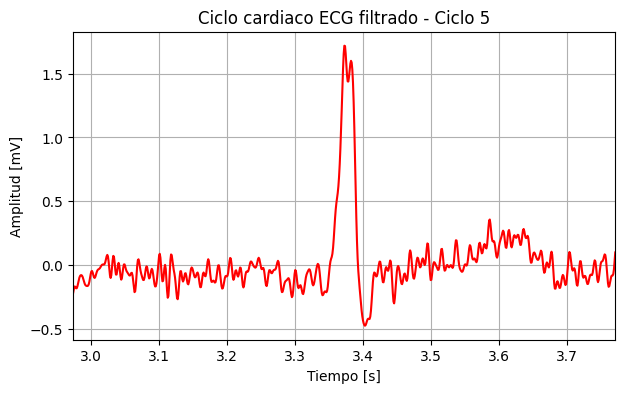

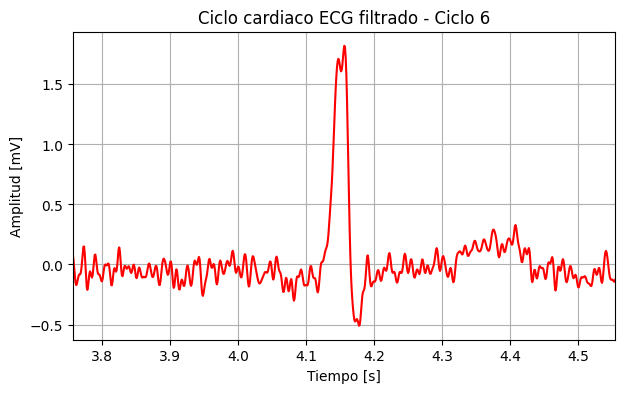

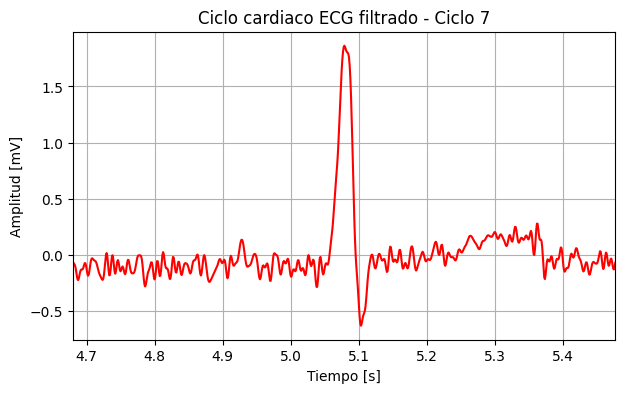

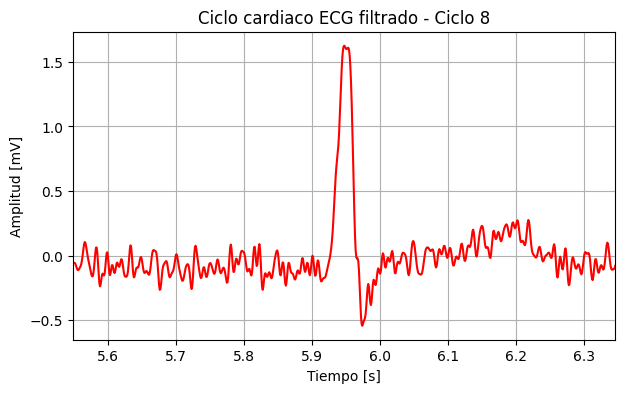

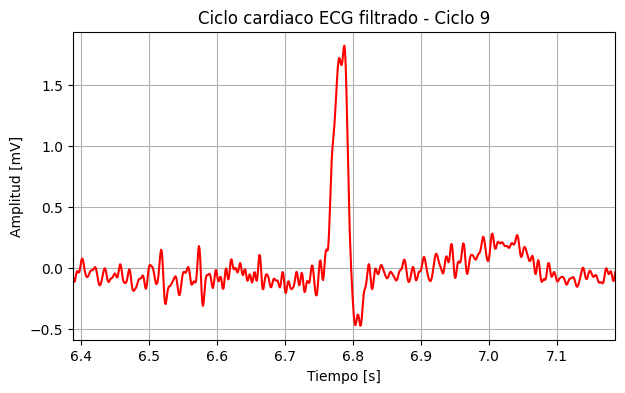

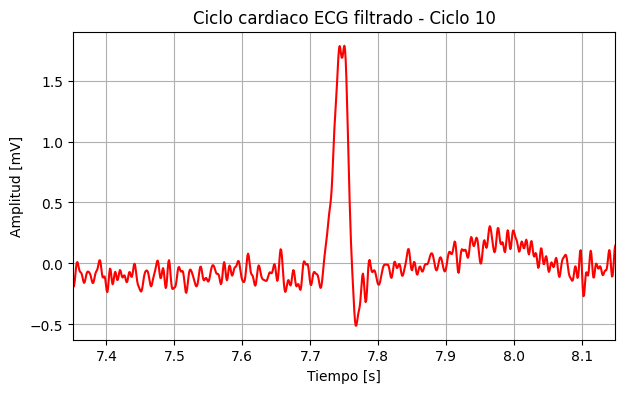

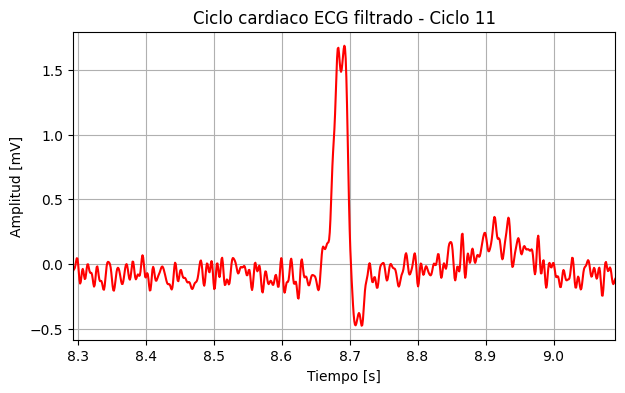

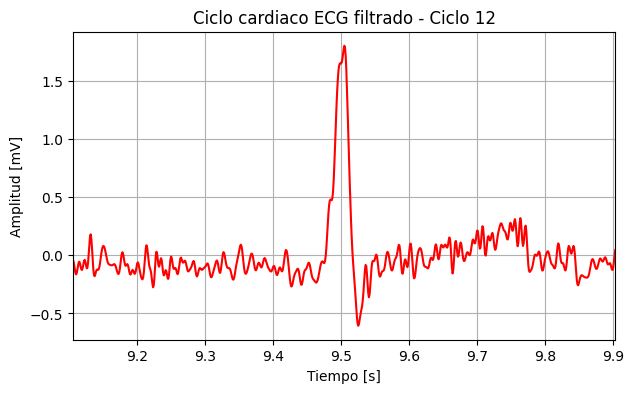

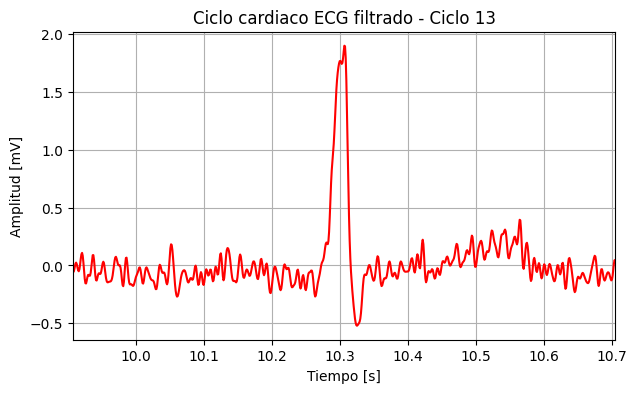

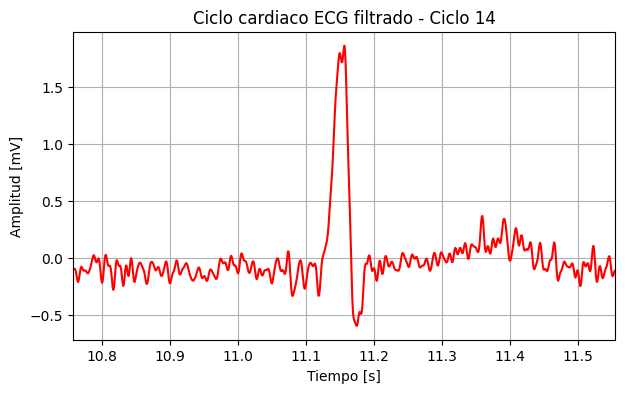

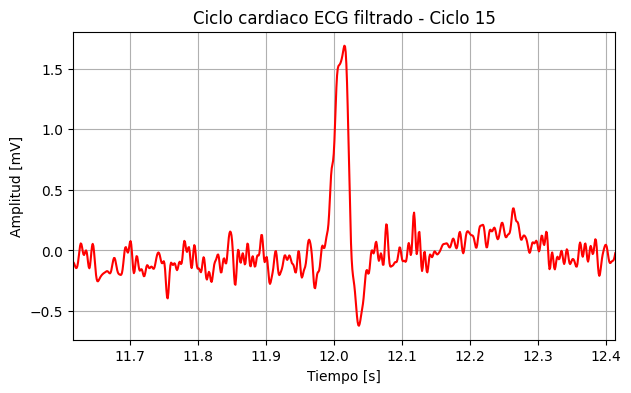

In [111]:
Fs = 1024
threshold_1 = int(0.4 * Fs) # Umbral hacia la izquierda, que determinará el inicio del ciclo.
threshold_2 = int(0.4 * Fs) #Umbral hacia la derecha, que determinará el final del ciclo.

peaks, _ = find_peaks(ECG_filtered_rs, distance=700, height=1000) #find_peaks nos ayudará a identificar los picos R.
#El parámetro distance se estableció en base a la visualización de los gráficos, de manera que los picos se identifiquen cada 700 ms
#Serán considerados picos a partir de una amplitud de 1000.

cycles_number = 15 #Se hará la extracción de 15 ciclos.
peaks = peaks[:cycles_number]

# Tamaño del segmento para cada ciclo
segment_size = threshold_1 + threshold_2

# Se inicializan los arrays en 0 para los ciclos y sus respectivos vectores de tiempo
cycles = np.zeros((cycles_number, segment_size), dtype=float)
time_vectors = np.zeros((cycles_number, segment_size), dtype=float)

#Se inicializa un ciclo for para empezar el proceso de extracción de los ciclos
for i, peak in enumerate(peaks):
    s = max(0, peak - threshold_1) #inicio
    e = min(len(ECG_filtered_rs), peak + threshold_2) #final

    # El tamaño de cada segmento será el final - el inicio
    segment_length = e - s
    if segment_length < segment_size:
        cycles[i, -segment_length:] = ECG_filtered_rs[s:e]
        time_vectors[i, -segment_length:] = time_vector[s:e]
    else:
        cycles[i] = ECG_filtered_rs[s:s + segment_size]
        time_vectors[i] = time_vector[s:s + segment_size]

for i in range(cycles_number):
    plt.figure(figsize=(7, 4))
    plt.plot(time_vectors[i], cycles[i]/1000, color='red')
    plt.title(f'Ciclo cardiaco ECG filtrado - Ciclo {i+1}')
    plt.xlabel('Tiempo [s]')
    plt.ylabel('Amplitud [mV]')
    plt.xlim(time_vectors[i][0], time_vectors[i][-1])
    plt.grid(True)
    plt.show()

In [112]:
Promedios = np.mean(cycles, axis=1)
Varianzas = np.var(cycles, axis=1)

In [113]:
metricas = pd.DataFrame({'Promedio': Promedios, 'Varianza': Varianzas}, index=[f'Ciclo {i+1}' for i in range(0,15)])

In [114]:
metricas

,Promedio,Varianza
Ciclo 1,109.527042,91047.994565
Ciclo 2,8.432600,88296.657260
Ciclo 3,-8.622884,87055.699228
Ciclo 4,-14.014065,77560.885480
Ciclo 5,9.954976,78658.081106
Ciclo 6,12.067757,87415.921773
Ciclo 7,-0.319505,91832.359841
Ciclo 8,-0.878497,75442.256680
Ciclo 9,13.020998,85922.428758
Ciclo 10,13.447980,85878.269433


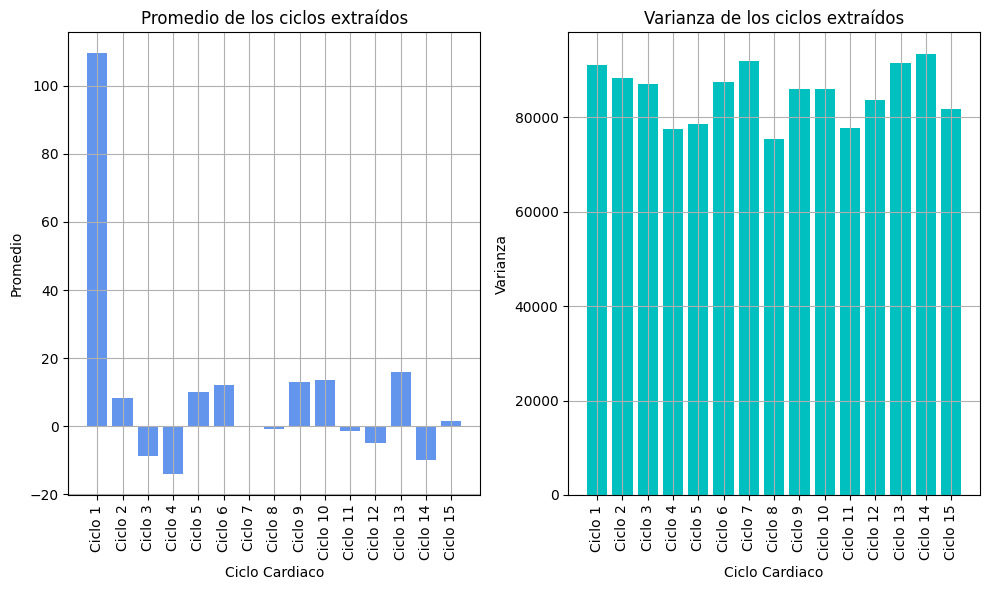

In [115]:
plt.figure(figsize=(10, 6))
plt.subplot(1,2,1)
plt.bar(np.arange(cycles_number), Promedios, width=0.8, color='#6495ED')
plt.xlabel('Ciclo Cardiaco')
plt.ylabel('Promedio')
plt.title('Promedio de los ciclos extraídos')
plt.xticks(np.arange(cycles_number), [f'Ciclo {i+1}' for i in range(cycles_number)], rotation=90)
plt.grid(True)

plt.subplot(1,2,2)
plt.bar(np.arange(cycles_number), Varianzas, width=0.8, color='#00BFBF')
plt.xlabel('Ciclo Cardiaco')
plt.ylabel('Varianza')
plt.title('Varianza de los ciclos extraídos')
plt.xticks(np.arange(cycles_number), [f'Ciclo {i+1}' for i in range(cycles_number)], rotation=90)
plt.grid(True)

plt.tight_layout()
plt.show()

Gráficamente podemos observar cómo los periodos refractarios de las señales varían con el tiempo. En cuanto a las medidas estadísticas, el promedio y la varianza presentan variación durante todos los ciclos extraídos, por tanto, la señal no puede ser considerada estacionaria.

<img src='Punto 6.jpeg'>

#### __Comparación entre ciclos, Prueba T__
Para llevar a cabo la Prueba T, primero realizamos una prueba de normalidad llamada Shapiro-Wilk utilizando la función stats.shapiro de SciPy, que verifica si los datos siguen una distribución normal. Luego, aplicamos la prueba de Levene con la función stats.levene para evaluar si las varianzas de varias muestras son iguales, asegurando que se cumpla el supuesto de homocedasticidad. A continuación, usamos la función stats.ttest_ind para realizar la Prueba T de independencia, que compara las medias de dos grupos independientes para detectar diferencias significativas.

Además, debido a que al realizar las compraraciones no se cumplieron los requisitos para las pruebas anteriores, realizamos la prueba U de Mann-Whitney con la función stats.mannwhitneyu. Esta prueba no paramétrica compara si dos muestras independientes provienen de la misma distribución.


#### __Comparación entre el ciclo 1 y el 5__


In [116]:
from statsmodels.stats.diagnostic import lilliefors

ciclo_1 = cycles[0]
ciclo_5 = cycles[4]

t_p = None
u_p = None

# 1. Prueba de Normalidad (Shapiro-Wilk o Kolmogorov-Smirnov)
# Shapiro-Wilk test
stat1, p1 = stats.shapiro(ciclo_1)
stat2, p2 = stats.shapiro(ciclo_5)

print(f'P-value ciclo 1 (Shapiro-Wilk): {p1}')
print(f'P-value ciclo 5 (Shapiro-Wilk): {p2}')

# Verificación de normalidad: p > 0.05 indica que los datos son normales
if p1 > 0.05 and p2 > 0.05:
    print("Ambos ciclos siguen una distribución normal.")
else:
    print("Al menos uno de los ciclos no sigue una distribución normal.")

# 2. Prueba de homocedasticidad (Prueba de Levene)
levene_stat, levene_p = stats.levene(ciclo_1, ciclo_5)
print(f'P-value de Levene: {levene_p}')

# Verificación de homocedasticidad: p > 0.05 indica que las varianzas son iguales
if levene_p > 0.05:
    print("Los ciclos tienen varianzas iguales (homocedasticidad).")
else:
    print("Los ciclos no tienen varianzas iguales (heterocedasticidad).")

# 3. Prueba t para muestras independientes (si se cumplen normalidad y homocedasticidad)
if p1 > 0.05 and p2 > 0.05 and levene_p > 0.05:
    t_stat, t_p = stats.ttest_ind(ciclo_1, ciclo_5)
    print(f'P-value de la prueba t: {t_p}')

    if t_p < 0.05:
        print("Existe una diferencia estadísticamente significativa entre los ciclos (Prueba t).")
    else:
        print("No existe una diferencia estadísticamente significativa entre los ciclos (Prueba t).")
else:
    print("No se cumplen los requisitos para la prueba t, se realizará la prueba U de Mann-Whitney.")

    # 4. Prueba no paramétrica: U de Mann-Whitney
    u_stat, u_p = stats.mannwhitneyu(ciclo_1, ciclo_5)
    print(f'P-value de la prueba U de Mann-Whitney: {u_p}')

    if u_p < 0.05:
        print("Existe una diferencia estadísticamente significativa entre los ciclos (Prueba U de Mann-Whitney).")
    else:
        print("No existe una diferencia estadísticamente significativa entre los ciclos (Prueba U de Mann-Whitney).")

# Discusión de la estacionariedad
if (t_p is not None and t_p < 0.05) or (u_p is not None and u_p < 0.05):
    print("El análisis indica una diferencia significativa entre los ciclos, lo que sugiere no estacionariedad.")
else:
    print("No hay diferencias significativas, lo que puede sugerir estacionariedad en la señal.")


P-value ciclo 1 (Shapiro-Wilk): 1.2782260430332817e-41
P-value ciclo 5 (Shapiro-Wilk): 6.432836811593373e-40
Al menos uno de los ciclos no sigue una distribución normal.
P-value de Levene: 0.9769390359242537
Los ciclos tienen varianzas iguales (homocedasticidad).
No se cumplen los requisitos para la prueba t, se realizará la prueba U de Mann-Whitney.
P-value de la prueba U de Mann-Whitney: 1.027598288616297e-49
Existe una diferencia estadísticamente significativa entre los ciclos (Prueba U de Mann-Whitney).
El análisis indica una diferencia significativa entre los ciclos, lo que sugiere no estacionariedad.


#### __Comparación entre el ciclo 3 y el 10__

In [78]:
from statsmodels.stats.diagnostic import lilliefors

ciclo_3 = cycles[2]
ciclo_10 = cycles[9]

# Inicializamos las variables t_p y u_p
t_p = None
u_p = None

# 1. Prueba de Normalidad (Shapiro-Wilk o Kolmogorov-Smirnov)
# Shapiro-Wilk test
stat1, p1 = stats.shapiro(ciclo_1)
stat2, p2 = stats.shapiro(ciclo_5)

print(f'P-value ciclo 1 (Shapiro-Wilk): {p1}')
print(f'P-value ciclo 5 (Shapiro-Wilk): {p2}')

# Verificación de normalidad: p > 0.05 indica que los datos son normales
if p1 > 0.05 and p2 > 0.05:
    print("Ambos ciclos siguen una distribución normal.")
else:
    print("Al menos uno de los ciclos no sigue una distribución normal.")

# 2. Prueba de homocedasticidad (Prueba de Levene)
levene_stat, levene_p = stats.levene(ciclo_1, ciclo_5)
print(f'P-value de Levene: {levene_p}')

# Verificación de homocedasticidad: p > 0.05 indica que las varianzas son iguales
if levene_p > 0.05:
    print("Los ciclos tienen varianzas iguales (homocedasticidad).")
else:
    print("Los ciclos no tienen varianzas iguales (heterocedasticidad).")

# 3. Prueba t para muestras independientes (si se cumplen normalidad y homocedasticidad)
if p1 > 0.05 and p2 > 0.05 and levene_p > 0.05:
    t_stat, t_p = stats.ttest_ind(ciclo_1, ciclo_5)
    print(f'P-value de la prueba t: {t_p}')

    if t_p < 0.05:
        print("Existe una diferencia estadísticamente significativa entre los ciclos (Prueba t).")
    else:
        print("No existe una diferencia estadísticamente significativa entre los ciclos (Prueba t).")
else:
    print("No se cumplen los requisitos para la prueba t, se realizará la prueba U de Mann-Whitney.")

    # 4. Prueba no paramétrica: U de Mann-Whitney
    u_stat, u_p = stats.mannwhitneyu(ciclo_1, ciclo_5)
    print(f'P-value de la prueba U de Mann-Whitney: {u_p}')

    if u_p < 0.05:
        print("Existe una diferencia estadísticamente significativa entre los ciclos (Prueba U de Mann-Whitney).")
    else:
        print("No existe una diferencia estadísticamente significativa entre los ciclos (Prueba U de Mann-Whitney).")

# Discusión de la estacionariedad
if (t_p is not None and t_p < 0.05) or (u_p is not None and u_p < 0.05):
    print("El análisis indica una diferencia significativa entre los ciclos, lo que sugiere no estacionariedad.")
else:
    print("No hay diferencias significativas, lo que puede sugerir estacionariedad en la señal.")

P-value ciclo 1 (Shapiro-Wilk): 1.2782260430332817e-41
P-value ciclo 5 (Shapiro-Wilk): 6.432836811593373e-40
Al menos uno de los ciclos no sigue una distribución normal.
P-value de Levene: 0.9769390359242537
Los ciclos tienen varianzas iguales (homocedasticidad).
No se cumplen los requisitos para la prueba t, se realizará la prueba U de Mann-Whitney.
P-value de la prueba U de Mann-Whitney: 1.027598288616297e-49
Existe una diferencia estadísticamente significativa entre los ciclos (Prueba U de Mann-Whitney).
El análisis indica una diferencia significativa entre los ciclos, lo que sugiere no estacionariedad.


Los resultados del análisis estadístico sugieren que la señal ECG no es estacionaria. Aunque los ciclos presentan homocedasticidad, la falta de normalidad en al menos uno de ellos y la diferencia estadísticamente significativa entre los ciclos (prueba U de Mann-Whitney, p-valor ≈ 1.03e-49) indicando que efectivamente las propiedades estadísticas de la señal, como la media y la varianza, varían con el tiempo. Esto confirma los cambios entre ciclos observados previamente. Cabe destacar que la no estacionariedad en señales ECG es habitual y puede reflejar variaciones naturales en el ritmo cardíaco o en las condiciones fisiológicas [2].

#### __Prueba de Dickey-Fuller__
Se aplica la prueba de Dickey-Fuller al último ciclo de la señal ECG usando la función adfuller de statsmodels. Esta prueba evalúa la estacionariedad de una serie temporal. Un p-valor menor a 0.05 sugiere que la serie es estacionaria, mientras que un p-valor mayor o igual a 0.05 indica no estacionariedad.

<img src='Punto 7.jpeg'>

In [117]:
from statsmodels.tsa.stattools import adfuller
ciclo_15=cycles[14]

# Realizar la prueba de Dickey-Fuller sobre este ciclo
resultado_dickey = adfuller(ciclo_15)

# Extraer los resultados
EstadDickeyFuller = resultado_dickey[0]
valor_p = resultado_dickey[1]
lags = resultado_dickey[2]
observaciones = resultado_dickey[3]
critical_values = resultado_dickey[4]

# Imprimir los resultados
print(f'Estadístico ADF: {EstadDickeyFuller}')
print(f'valor P: {valor_p}')
print(f'Número de lags usados: {lags}')
print(f'Número de observaciones: {observaciones}')
print('Valores críticos:')
for i, n in critical_values.items():
    print(f'   {i}: {n}')

# Interpretar los resultados
if valor_p < 0.05:
    print("La señal es estacionaria según la prueba de Dickey-Fuller (p < 0.05).")
else:
    print("La señal NO es estacionaria según la prueba de Dickey-Fuller (p >= 0.05).")


Estadístico ADF: -1.6792992537686287
valor P: 0.4418084400514369
Número de lags usados: 18
Número de observaciones: 799
Valores críticos:
   1%: -3.4385608049885876
   5%: -2.865164107438179
   10%: -2.5686998068142124
La señal NO es estacionaria según la prueba de Dickey-Fuller (p >= 0.05).



La prueba de Dickey-Fuller confirma que la señal ECG no es estacionaria, con un p-valor de 0.4418, significativamente mayor al umbral de 0,05.

####__Conclusiones__

*   La señal ECG cruda presentaba problemas de calidad, como una línea base inestable y un offset. Tras aplicar filtros pasa altas (0.5 Hz) y pasa bajas (40 Hz), se logró mejorar significativamente la señal, eliminando el offset, estabilizando la línea base y reduciendo el ruido y los artefactos, obteniendo así una señal más clara y adecuada para el análisis.

*   la señal ECG sin filtrar presentó altos valores de media y RMS debido al ruido y tendencias lineales. El proceso de filtrado logró reducir estos valores, mejorando la calidad general de la señal. Aunque se observó un ligero aumento en las medidas de variabilidad tras el filtrado, esto es considerado normal en señales ECG. La persistencia de una alta variabilidad incluso después del filtrado refleja las características naturales y dinámicas de la actividad cardíaca.

*  Los análisis estadísticos y las pruebas realizadas confirmaron que la señal no es estacionaria. La prueba U de Mann-Whitney reveló diferencias significativas entre ciclos (p-valor ≈ 1.03e-49), y la prueba de Dickey-Fuller corroboró la no estacionariedad (p-valor = 0.4418). Además, se observaron variaciones en los periodos refractarios, promedios y varianzas entre ciclo.




####__Referencias__

[1] J. Romero, “Análisis de señales electrocardiográficas usando técnicas de procesamiento digital”, Univ. Oberta Catalunya, 2015. [En línea]. Disponible: https://openaccess.uoc.edu/bitstream/10609/40186/6/jlorenzoroTFC0115memoria.pdf

[2] O. Vera, E. Cardona y J. Rivera, “EXTRACCIÓN DE CARACTERÍSTICAS DE LA SEÑAL ELECTROCARDIOGRÁFICA MEDIANTE SOFTWARE DE ANÁLISIS MATEMÁTICO”, Sci. Tech., n.º 31, 2006. [En línea]. Disponible: https://dialnet.unirioja.es/descarga/articulo/4829335.pdf